# Predictive Maintenance

Dataset taken from

http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv

PROJECT: Maintenance cost reduction through predictive techniques

BACKGROUND
A company has a fleet of devices transmitting daily telemetry readings. They would like to create a predictive
maintenance solution to proactively identify when maintenance should be performed. This approach promises cost
savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

GOAL
You are tasked with building a predictive model using machine learning to predict the probability of a device failure.
When building this model, be sure to minimize false positives and false negatives. The column you are trying to predict is called failure with binary value 0 for non-failure and 1 for failure.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read the Dataset

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectFromModel

from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.models  import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

%matplotlib inline
print('Done !!!')

Done !!!


# Load Split and Scale Dataset

In [15]:

def load_split_scale():
  
    file_dir = Path('/content/drive/My Drive/Data_Science/projects/predictive_maintenance/data')
    # file_dir = Path('/Users/khan_m_a/Google Drive/Data_Science/projects/predictive_maintenance/data')


    df_one_hot = pd.read_csv( file_dir / 'df_one_hot.csv',
                 parse_dates = True, index_col = 'date',
                 delimiter = ',')
    print('Loaded Dateset')

    # make X and y 
    X = df_one_hot.drop('failure', axis =1).values
    y = df_one_hot.failure.values

    # check sizes
    print('X and y sizes are :', X.shape, y.shape)

    # make statify = y for imbalanced dataset
    X_train1, X_test, y_train1, y_test = train_test_split(X, y, 
                              test_size = 0.2, stratify = y )
    
    X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, 
                              test_size = 0.2, stratify =  y_train1)
    
    print('X_train, X_val, and X_test sizes are ', X_train.shape, X_val.shape, X_test.shape )
    
    # check if failure is equally distribute.
    print('failures in train, val, and test are :', y_train.sum(), y_val.sum(), y_test.sum())
    

    # Apply standardization to X_train and X_test
    # scaler = MinMaxScaler()
    scaler1, scaler2, scaler3 = StandardScaler(), StandardScaler(), StandardScaler()
    X_train = scaler1.fit_transform(X_train) # fit and transform on X_train
    X_val = scaler2.fit_transform(X_val) # fit and transform X_val
    X_test = scaler3.fit_transform(X_test) # fit and transform X_test
    
    # remove all point above and below 5   
    X_train = np.clip(X_train, -5, 5)
    X_test = np.clip(X_test, -5, 5)
    X_val = np.clip(X_val, -5, 5)
    
    # check scaled 
    print('Train scaled', X_train[0:3], y[0:3])
    print('Val scaled', X_val[0:3], y[0:3])
    print('Test scaled', X_test[0:3], y[0:3])
    
    return df_one_hot, X_train, X_val, X_test, y_train, y_val, y_test


df_one_hot, X_train, X_val, X_test, y_train, y_val, y_test = load_split_scale()
print('Done !!!')

Loaded Dateset
X and y sizes are : (124494, 1177) (124494,)
X_train, X_val, and X_test sizes are  (79676, 1177) (19919, 1177) (24899, 1177)
failures in train, val, and test are : 68 17 21
Train scaled [[ 0.36652186 -0.07399818 -0.04905295 ... -0.02699034 -0.02480664
  -0.02505864]
 [-0.50074803 -0.07399818 -0.04905295 ... -0.02699034 -0.02480664
  -0.02505864]
 [ 1.33365036 -0.07399818 -0.04905295 ... -0.02699034 -0.02480664
  -0.02505864]] [0 0 0]
Val scaled [[ 0.6665555  -0.07199203 -0.07723703 ... -0.02455205 -0.02350621
  -0.02922645]
 [ 1.44159594 -0.07199203 -0.07723703 ... -0.02455205 -0.02350621
  -0.02922645]
 [ 1.71428538 -0.07199203 -0.07723703 ... -0.02455205 -0.02350621
  -0.02922645]] [0 0 0]
Test scaled [[ 0.17454216 -0.07223659  2.19968318 ... -0.02371894 -0.03106162
  -0.02535763]
 [ 0.62044149 -0.07223659 -0.07627712 ... -0.02371894 -0.03106162
  -0.02535763]
 [ 0.65673727 -0.07223659 -0.06762328 ... -0.02371894 -0.03106162
  -0.02535763]] [0 0 0]
Done !!!


# Logistic Classification

In [ ]:

clf_lr = LogisticRegression(class_weight = 'balanced' , max_iter=1000)
clf_lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
pred_lr_tr = clf_lr.predict(X_train)
pred_lr_val = clf_lr.predict(X_val)
pred_lr_te = clf_lr.predict(X_test)
print(pred_lr_te.shape)

(24899,)


In [ ]:
print('Train Accuracy Score - ',accuracy_score(pred_lr_tr, y_train))
print('Val Accuracy Score - ',accuracy_score(pred_lr_val, y_val))
print('Test Accuracy Score - ',accuracy_score(pred_lr_te, y_test))

Train Accuracy Score -  0.9781992067874893
Val Accuracy Score -  0.9778603343541342
Test Accuracy Score -  0.9763444315032732


In [ ]:
cm_prob_threshold = 0.65

tn, fp, fn, tp [[77871     0]
 [ 1737    68]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     77871
           1       1.00      0.04      0.07      1805

    accuracy                           0.98     79676
   macro avg       0.99      0.52      0.53     79676
weighted avg       0.98      0.98      0.97     79676



Text(0.5, 15.0, 'Predicted label')

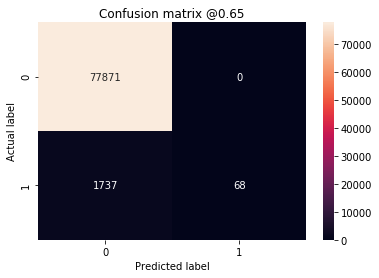

In [ ]:
# confusion matrix on Train
'''
                    Predicted
                  0          1
        0         TN         FP
Actual 
        1         FN         TP
'''


conf_matrix_lr_tr = confusion_matrix(pred_lr_tr > cm_prob_threshold, y_train )
print('tn, fp, fn, tp', confusion_matrix(pred_lr_tr, y_train ))
# print(conf_matrix_lr_tr)

conf_matrix_lr_report_tr = classification_report(pred_lr_tr, y_train )
print(conf_matrix_lr_report_tr)
sns.heatmap(conf_matrix_lr_tr, annot=True, fmt = 'd')
plt.title('Confusion matrix @{:.2f}'.format(cm_prob_threshold))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


tn, fp, fn, tp [[19474    13]
 [  428     4]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19487
           1       0.24      0.01      0.02       432

    accuracy                           0.98     19919
   macro avg       0.61      0.50      0.50     19919
weighted avg       0.96      0.98      0.97     19919



Text(0.5, 15.0, 'Predicted label')

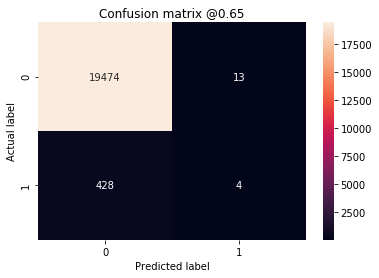

In [ ]:
# confusion matrix on Val
'''
                    Predicted
                  0          1
        0         TN         FP
Actual 
        1         FN         TP
'''


conf_matrix_lr_val = confusion_matrix(pred_lr_val > cm_prob_threshold, y_val )
print('tn, fp, fn, tp', confusion_matrix(pred_lr_val, y_val ))
# print(conf_matrix_lr_val)

conf_matrix_lr_report_val = classification_report(pred_lr_val, y_val )
print(conf_matrix_lr_report_val)
sns.heatmap(conf_matrix_lr_val, annot=True, fmt = 'd')
plt.title('Confusion matrix @{:.2f}'.format(cm_prob_threshold))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

tn, fp, fn, tp [[24307    18]
 [  571     3]]
[[24307    18]
 [  571     3]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     24325
           1       0.14      0.01      0.01       574

    accuracy                           0.98     24899
   macro avg       0.56      0.50      0.50     24899
weighted avg       0.96      0.98      0.97     24899



Text(0.5, 15.0, 'Predicted label')

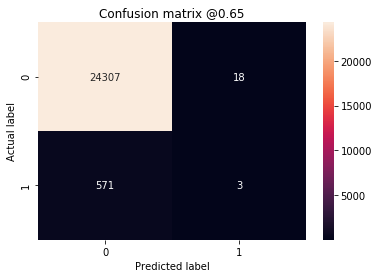

In [ ]:
# confusion matrix on Test
'''
                    Predicted
                  0          1
        0         TN         FP
Actual 
        1         FN         TP
'''


conf_matrix_lr_te = confusion_matrix(pred_lr_te, y_test )
print('tn, fp, fn, tp', confusion_matrix(pred_lr_te, y_test ))
print(conf_matrix_lr_te)

conf_matrix_lr_report_te = classification_report(pred_lr_te, y_test )
print(conf_matrix_lr_report_te)
sns.heatmap(conf_matrix_lr_te, annot=True, fmt = 'd')
plt.title('Confusion matrix @{:.2f}'.format(cm_prob_threshold))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [ ]:
# trying ROC Curve
pred_lr_tr_proba = clf_lr.predict_proba(X_train)
pred_lr_val_proba = clf_lr.predict_proba(X_val)
pred_lr_te_proba = clf_lr.predict_proba(X_test)

In [ ]:
pred_lr_tr_proba = pred_lr_tr_proba[:,1]
pred_lr_val_proba = pred_lr_val_proba[:,1]
pred_lr_te_proba = pred_lr_te_proba[:,1]

In [ ]:
pred_lr_te_proba[0:10]

array([3.24296545e-17, 7.02022693e-10, 3.51057566e-07, 3.51164879e-08,
       6.96782978e-10, 2.32492124e-17, 2.88906751e-05, 4.05046064e-10,
       1.65157813e-10, 4.19753435e-10])

In [ ]:
roc_acc_lr_tr = roc_auc_score( y_train, pred_lr_tr_proba)
roc_acc_lr_val = roc_auc_score( y_val, pred_lr_val_proba)
roc_acc_lr_te = roc_auc_score( y_test, pred_lr_te_proba)
print('ROC score is ', roc_acc_lr_tr)
print('ROC score is ', roc_acc_lr_val)
print('ROC score is ', roc_acc_lr_te)

ROC score is  0.9977665376521426
ROC score is  0.7560901357829837
ROC score is  0.7148369758708211


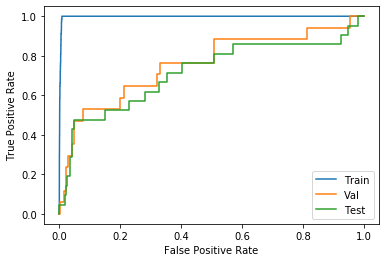

In [ ]:
# drawing ROC curve
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

lr_fpr_rf_tr, lr_tpr_rf_tr, _ = roc_curve(y_train, pred_lr_tr_proba)
lr_fpr_rf_val, lr_tpr_rf_val, _ = roc_curve(y_val, pred_lr_val_proba)
lr_fpr_rf_te, lr_tpr_rf_te, _ = roc_curve(y_test, pred_lr_te_proba)
plt.plot(lr_fpr_rf_tr, lr_tpr_rf_tr, label = 'Train')
plt.plot(lr_fpr_rf_val, lr_tpr_rf_val, label = 'Val')
plt.plot(lr_fpr_rf_te, lr_tpr_rf_te, label = 'Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Random Forest

In [128]:
#base line model
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring

scoring = ['neg_log_loss', 'accuracy', 'roc_auc', 'precision', 'recall']

# balanced class_weight with RepeatedStratififiedKFold
clf_rf = RandomForestClassifier( max_depth= 10,
                                n_estimators = 10, random_state =42)

# fit the model
clf_rf.fit(X_train, y_train)

# cross evaluation prodedure
cv = RepeatedStratifiedKFold(n_splits = 5 ,
                             n_repeats = 1,random_state = 42)

scores_tr = cross_validate(clf_rf, X_train, y_train,scoring = scoring,
                          cv =cv, n_jobs = -1)

# print results
print(' ROC AUC :',scores_tr)
print('Train neg log is ',scores_tr['test_neg_log_loss'])
print('Train accuracy is ',scores_tr['test_accuracy'])
print('Train precision is ',scores_tr['test_precision'])
print('Train recall is ',scores_tr['test_recall'])
print('Train ROC is ',scores_tr['test_roc_auc'])

 ROC AUC : {'fit_time': array([5.58876467, 5.53143692, 5.46782494, 5.4874332 , 3.15464616]), 'score_time': array([0.24808359, 0.25667667, 0.25219083, 0.25385571, 0.14962959]), 'test_neg_log_loss': array([-0.00620413, -0.00661173, -0.00601976, -0.00631889, -0.00611564]), 'test_accuracy': array([0.99912149, 0.99918419, 0.99918419, 0.99905868, 0.99912143]), 'test_roc_auc': array([0.68461652, 0.74138831, 0.62414125, 0.71980852, 0.8988914 ]), 'test_precision': array([0., 0., 0., 0., 0.]), 'test_recall': array([0., 0., 0., 0., 0.])}
Train neg log is  [-0.00620413 -0.00661173 -0.00601976 -0.00631889 -0.00611564]
Train accuracy is  [0.99912149 0.99918419 0.99918419 0.99905868 0.99912143]
Train precision is  [0. 0. 0. 0. 0.]
Train recall is  [0. 0. 0. 0. 0.]
Train ROC is  [0.68461652 0.74138831 0.62414125 0.71980852 0.8988914 ]


# RF - class_weight model

In [145]:
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring

scoring = ['neg_log_loss', 'accuracy', 'roc_auc', 'precision', 'recall']

# balanced class_weight with RepeatedStratififiedKFold
clf_rf = RandomForestClassifier(class_weight = 'balanced', max_depth= 10,
                                n_estimators = 10, random_state =42)

# fit the model
clf_rf.fit(X_train, y_train)

# cross evaluation prodedure
cv = RepeatedStratifiedKFold(n_splits = 5 ,
                             n_repeats = 1,random_state = 42)


scores_tr = cross_validate(clf_rf, X_train, y_train,scoring = scoring,
                          cv =cv, n_jobs = -1)

# print results
print(' ROC AUC :',scores_tr)
print('Train neg log is ',scores_tr['test_neg_log_loss'])
print('Train accuracy is ',scores_tr['test_accuracy'])
print('Train precision is ',scores_tr['test_precision'])
print('Train recall is ',scores_tr['test_recall'])
print('Train ROC is ',scores_tr['test_roc_auc'])

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


 ROC AUC : {'fit_time': array([6.00028849, 6.1996367 , 5.39070058, 5.3835516 , 3.04251027]), 'score_time': array([0.26106644, 0.2448101 , 0.26700234, 0.31567764, 0.15314484]), 'test_neg_log_loss': array([-0.36399872, -0.40880501, -0.43971813, -0.3555837 , -0.34969989]), 'test_accuracy': array([0.96906376, 0.95651083, 0.97615312, 0.98079699, 0.96435519]), 'test_roc_auc': array([0.78943107, 0.81837902, 0.82952953, 0.70389288, 0.96739033]), 'test_precision': array([0.01616162, 0.00867052, 0.01583113, 0.01655629, 0.01232394]), 'test_recall': array([0.57142857, 0.46153846, 0.46153846, 0.35714286, 0.5       ])}
Train neg log is  [-0.36399872 -0.40880501 -0.43971813 -0.3555837  -0.34969989]
Train accuracy is  [0.96906376 0.95651083 0.97615312 0.98079699 0.96435519]
Train precision is  [0.01616162 0.00867052 0.01583113 0.01655629 0.01232394]
Train recall is  [0.57142857 0.46153846 0.46153846 0.35714286 0.5       ]
Train ROC is  [0.78943107 0.81837902 0.82952953 0.70389288 0.96739033]


In [146]:
# ROC caculation
pred_rf_tr_proba = clf_rf.predict_proba(X_train)
pred_rf_val_proba = clf_rf.predict_proba(X_val)
pred_rf_te_proba = clf_rf.predict_proba(X_test)

pred_rf_tr_proba[0:10]
pred_rf_val_proba[0:10]
pred_rf_te_proba[0:10]


#only the second column is needed
pred_rf_tr_proba_1 = [p[1] for p in pred_rf_tr_proba]
pred_rf_val_proba_1 = [p[1] for p in pred_rf_val_proba]
pred_rf_te_proba_1 = [p[1] for p in pred_rf_te_proba]


roc_acc_rf_tr = roc_auc_score( y_train, pred_rf_tr_proba_1)
roc_acc_rf_val = roc_auc_score( y_val, pred_rf_val_proba_1)
roc_acc_rf_te = roc_auc_score( y_test, pred_rf_te_proba_1)
print('Train ROC score is ', roc_acc_rf_tr)
print('val ROC score is ', roc_acc_rf_val)
print('Test ROC score is ', roc_acc_rf_te)

Train ROC score is  0.9591803144230258
val ROC score is  0.7850895860303724
Test ROC score is  0.7534157163146631


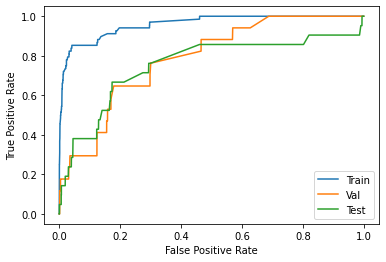

In [147]:
# drawing ROC curve
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

lr_fpr_rf_tr, lr_tpr_rf_tr, _ = roc_curve(y_train, pred_rf_tr_proba_1)
lr_fpr_rf_val, lr_tpr_rf_val, _ = roc_curve(y_val, pred_rf_val_proba_1)
lr_fpr_rf_te, lr_tpr_rf_te, _ = roc_curve(y_test, pred_rf_te_proba_1)
plt.plot(lr_fpr_rf_tr, lr_tpr_rf_tr, label = 'Train')
plt.plot(lr_fpr_rf_val, lr_tpr_rf_val, label = 'Val')
plt.plot(lr_fpr_rf_te, lr_tpr_rf_te, label = 'Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# RF Feature Importance

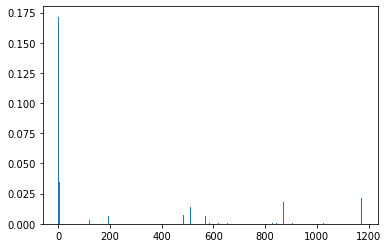

In [148]:
# get importance
importance = clf_rf.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [149]:
importance[0:10]

array([0.04210031, 0.17151581, 0.0272445 , 0.12877475, 0.11349032,
       0.03494659, 0.03860399, 0.04465481, 0.        , 0.        ])

In [150]:
#select top 10 most important feaure
top_10_imp = np.argsort(importance)[::-1] # sort reverse order
top_10_imp = importance[0:10]
top_10_imp

array([0.04210031, 0.17151581, 0.0272445 , 0.12877475, 0.11349032,
       0.03494659, 0.03860399, 0.04465481, 0.        , 0.        ])

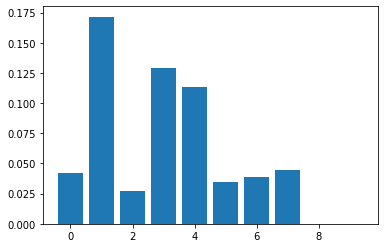

In [155]:
plt.bar([x for x in range(len(top_10_imp))], top_10_imp)
plt.show()

In [151]:
X_train_top_10 = X_train[: , [1,   3,   4,   7,   0, 109,   6,   5, 542,   2]]
X_val_top_10 = X_val[: , [1,   3,   4,   7,   0, 109,   6,   5, 542,   2]]
X_test_top_10 = X_test[: , [1,   3,   4,   7,   0, 109,   6,   5, 542,   2]]
X_train_top_10.shape

(79676, 10)

In [156]:
# Train again with important features
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring

scoring = ['neg_log_loss', 'accuracy', 'roc_auc', 'precision', 'recall']

# balanced class_weight with RepeatedStratififiedKFold
clf_rf = RandomForestClassifier(class_weight = 'balanced', max_depth= 3,
                                n_estimators = 10, random_state =42)

# fit the model
clf_rf.fit(X_train_top_10, y_train)

# cross evaluation prodedure
cv = RepeatedStratifiedKFold(n_splits = 5 ,
                             n_repeats = 1,random_state = 42)


scores_tr = cross_validate(clf_rf, X_train_top_10, y_train,scoring = scoring,
                          cv =cv, n_jobs = -1)

# print results
print(' ROC AUC :',scores_tr)
print('Train neg log is ',scores_tr['test_neg_log_loss'])
print('Train accuracy is ',scores_tr['test_accuracy'])
print('Train precision is ',scores_tr['test_precision'])
print('Train recall is ',scores_tr['test_recall'])
print('Train ROC is ',scores_tr['test_roc_auc'])

 ROC AUC : {'fit_time': array([0.45768881, 0.4408834 , 0.45206141, 0.50028014, 0.32220602]), 'score_time': array([0.06238341, 0.05833554, 0.05601954, 0.06232357, 0.03717422]), 'test_neg_log_loss': array([-0.34068186, -0.32401306, -0.36201986, -0.31496886, -0.34580109]), 'test_accuracy': array([0.92953062, 0.95324757, 0.93862567, 0.92877314, 0.94565422]), 'test_roc_auc': array([0.86798365, 0.79224199, 0.93564541, 0.77543137, 0.7537215 ]), 'test_precision': array([0.0079858 , 0.00806452, 0.00915565, 0.00529568, 0.00808314]), 'test_recall': array([0.64285714, 0.46153846, 0.69230769, 0.42857143, 0.5       ])}
Train neg log is  [-0.34068186 -0.32401306 -0.36201986 -0.31496886 -0.34580109]
Train accuracy is  [0.92953062 0.95324757 0.93862567 0.92877314 0.94565422]
Train precision is  [0.0079858  0.00806452 0.00915565 0.00529568 0.00808314]
Train recall is  [0.64285714 0.46153846 0.69230769 0.42857143 0.5       ]
Train ROC is  [0.86798365 0.79224199 0.93564541 0.77543137 0.7537215 ]


In [157]:
# ROC caculation
pred_rf_tr_proba = clf_rf.predict_proba(X_train_top_10)
pred_rf_val_proba = clf_rf.predict_proba(X_val_top_10)
pred_rf_te_proba = clf_rf.predict_proba(X_test_top_10)

pred_rf_tr_proba[0:10]
pred_rf_val_proba[0:10]
pred_rf_te_proba[0:10]


#only the second column is needed
pred_rf_tr_proba_1 = [p[1] for p in pred_rf_tr_proba]
pred_rf_val_proba_1 = [p[1] for p in pred_rf_val_proba]
pred_rf_te_proba_1 = [p[1] for p in pred_rf_te_proba]


roc_acc_rf_tr = roc_auc_score( y_train, pred_rf_tr_proba_1)
roc_acc_rf_val = roc_auc_score( y_val, pred_rf_val_proba_1)
roc_acc_rf_te = roc_auc_score( y_test, pred_rf_te_proba_1)
print('Train ROC score is ', roc_acc_rf_tr)
print('val ROC score is ', roc_acc_rf_val)
print('Test ROC score is ', roc_acc_rf_te)

Train ROC score is  0.921804156543534
val ROC score is  0.8806800380688905
Test ROC score is  0.8382008965657167


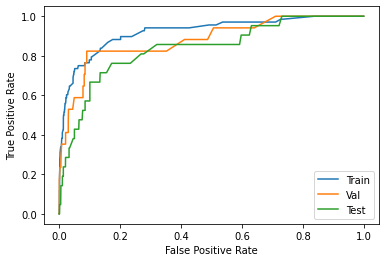

In [158]:
# drawing ROC curve
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

lr_fpr_rf_tr, lr_tpr_rf_tr, _ = roc_curve(y_train, pred_rf_tr_proba_1)
lr_fpr_rf_val, lr_tpr_rf_val, _ = roc_curve(y_val, pred_rf_val_proba_1)
lr_fpr_rf_te, lr_tpr_rf_te, _ = roc_curve(y_test, pred_rf_te_proba_1)
plt.plot(lr_fpr_rf_tr, lr_tpr_rf_tr, label = 'Train')
plt.plot(lr_fpr_rf_val, lr_tpr_rf_val, label = 'Val')
plt.plot(lr_fpr_rf_te, lr_tpr_rf_te, label = 'Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


# RF other models

In [159]:
# Subsample balanced class_weight with RepeatedStratififiedKFold
clf_rf = RandomForestClassifier(class_weight = 'balanced_subsample',
                                n_estimators = 10, random_state =42)

# cross evaluation prodedure
cv = RepeatedStratifiedKFold(n_splits = 6 ,
                             n_repeats = 2,random_state = 42)

# evaluate model
scores = cross_val_score(clf_rf, X_train, y_train,
                         scoring = 'roc_auc', cv =cv, n_jobs = -1)

# print results
print(' ROC AUC :',scores)

 ROC AUC : [0.54043563 0.54032258 0.5894942  0.58956272 0.54412188 0.58936059
 0.70659984 0.54030374 0.5890968  0.5442041  0.63472264 0.49894483]


In [160]:
# new library imbalanced-learn
# https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.BalancedRandomForestClassifier.html
# BalancedRandomForest with RepeatedStratififiedKFold

from imblearn.ensemble import BalancedRandomForestClassifier

clf_rf = BalancedRandomForestClassifier(n_estimators = 10, random_state =42)

# cross evaluation prodedure
cv = RepeatedStratifiedKFold(n_splits = 6 ,
                             n_repeats = 2,random_state = 42)

# evaluate model
scores = cross_val_score(clf_rf, X_train, y_train,
                         scoring = 'roc_auc', cv =cv, n_jobs = -1)

# print results
print(' ROC AUC :',scores)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

 ROC AUC : [nan nan nan nan nan nan nan nan nan nan nan nan]


In [161]:
# new library imbalanced-learn
# https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.BalancedRandomForestClassifier.html
# EasyEnsembleClassifier with RepeatedStratififiedKFold

from imblearn.ensemble import EasyEnsembleClassifier

clf_rf = EasyEnsembleClassifier(n_estimators = 10, random_state =42)

# cross evaluation prodedure
cv = RepeatedStratifiedKFold(n_splits = 6 ,
                             n_repeats = 2,random_state = 42)

# evaluate model
scores = cross_val_score(clf_rf, X_train, y_train,
                         scoring = 'roc_auc', cv =cv, n_jobs = -1)

# print results
print(' ROC AUC :',scores)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


 ROC AUC : [0.88859788 0.80911466 0.86565078 0.87916929 0.86581865 0.92639502
 0.89023716 0.81542056 0.79615685 0.92950229 0.90966988 0.87378381]


# RF Confusion Matrices

In [163]:
# Train again with important features
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring

scoring = ['neg_log_loss', 'accuracy', 'roc_auc', 'precision', 'recall']

# balanced class_weight with RepeatedStratififiedKFold
clf_rf = RandomForestClassifier(class_weight = 'balanced', max_depth= 3,
                                n_estimators = 10, random_state =42)

# fit the model
clf_rf.fit(X_train_top_10, y_train)

# cross evaluation prodedure
cv = RepeatedStratifiedKFold(n_splits = 5 ,
                             n_repeats = 1,random_state = 42)


scores_tr = cross_validate(clf_rf, X_train_top_10, y_train,scoring = scoring,
                          cv =cv, n_jobs = -1)

# print results
print(' ROC AUC :',scores_tr)
print('Train neg log is ',scores_tr['test_neg_log_loss'])
print('Train accuracy is ',scores_tr['test_accuracy'])
print('Train precision is ',scores_tr['test_precision'])
print('Train recall is ',scores_tr['test_recall'])
print('Train ROC is ',scores_tr['test_roc_auc'])

 ROC AUC : {'fit_time': array([0.42432761, 0.42754602, 0.40750837, 0.41814661, 0.29160714]), 'score_time': array([0.05971289, 0.06708431, 0.05736327, 0.06863928, 0.0374167 ]), 'test_neg_log_loss': array([-0.34068186, -0.32401306, -0.36201986, -0.31496886, -0.34580109]), 'test_accuracy': array([0.92953062, 0.95324757, 0.93862567, 0.92877314, 0.94565422]), 'test_roc_auc': array([0.86798365, 0.79224199, 0.93564541, 0.77543137, 0.7537215 ]), 'test_precision': array([0.0079858 , 0.00806452, 0.00915565, 0.00529568, 0.00808314]), 'test_recall': array([0.64285714, 0.46153846, 0.69230769, 0.42857143, 0.5       ])}
Train neg log is  [-0.34068186 -0.32401306 -0.36201986 -0.31496886 -0.34580109]
Train accuracy is  [0.92953062 0.95324757 0.93862567 0.92877314 0.94565422]
Train precision is  [0.0079858  0.00806452 0.00915565 0.00529568 0.00808314]
Train recall is  [0.64285714 0.46153846 0.69230769 0.42857143 0.5       ]
Train ROC is  [0.86798365 0.79224199 0.93564541 0.77543137 0.7537215 ]


In [198]:
# predict with probability
pred_rf_tr = clf_rf.predict_proba(X_train_top_10)
pred_rf_val = clf_rf.predict_proba(X_val_top_10)
pred_rf_te = clf_rf.predict_proba(X_test_top_10)

# consider ony second column
print(pred_rf_tr[0:10])

pred_rf_tr = np.delete(pred_rf_tr, [0], axis=1)
pred_rf_val = np.delete(pred_rf_val, [0], axis=1)
pred_rf_te = np.delete(pred_rf_te, [0], axis=1)

print(pred_rf_tr[0:10])

[[0.77180506 0.22819494]
 [0.77180506 0.22819494]
 [0.81907353 0.18092647]
 [0.74677035 0.25322965]
 [0.76576698 0.23423302]
 [0.77180506 0.22819494]
 [0.77180506 0.22819494]
 [0.8000769  0.1999231 ]
 [0.70540386 0.29459614]
 [0.74481765 0.25518235]]
[[0.22819494]
 [0.22819494]
 [0.18092647]
 [0.25322965]
 [0.23423302]
 [0.22819494]
 [0.22819494]
 [0.1999231 ]
 [0.29459614]
 [0.25518235]]


In [199]:
cm_prob_threshold = 0.5

              precision    recall  f1-score   support

       False       0.92      1.00      0.96     73380
        True       0.75      0.01      0.02      6296

    accuracy                           0.92     79676
   macro avg       0.84      0.50      0.49     79676
weighted avg       0.91      0.92      0.88     79676



Text(0.5, 15.0, 'Predicted label')

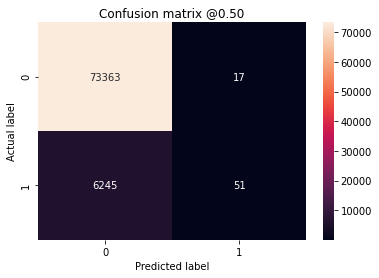

In [200]:
# confusion matrix for train
'''
                    Predicted
                  0          1
        0         TN         FP
Actual 
        1         FN         TP
'''

conf_matrix_rf_tr = confusion_matrix(pred_rf_tr >cm_prob_threshold, y_train )

# print(conf_matrix_rf_tr)

conf_matrix_rf_report_tr = classification_report(pred_rf_tr > cm_prob_threshold, y_train )
print(conf_matrix_rf_report_tr)
sns.heatmap(conf_matrix_rf_tr, annot=True, fmt = 'd')
plt.title('Confusion matrix @{:.2f}'.format(cm_prob_threshold))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

              precision    recall  f1-score   support

       False       0.92      1.00      0.96     18358
        True       0.65      0.01      0.01      1561

    accuracy                           0.92     19919
   macro avg       0.78      0.50      0.49     19919
weighted avg       0.90      0.92      0.89     19919



Text(0.5, 15.0, 'Predicted label')

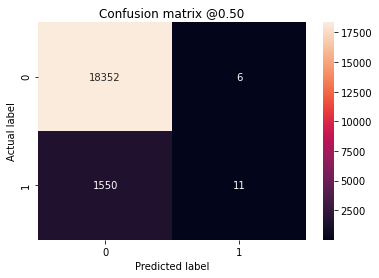

In [203]:
# confusion matrix for Val
'''
                    Predicted
                  0          1
        0         TN         FP
Actual 
        1         FN         TP
'''

conf_matrix_rf_val = confusion_matrix(pred_rf_val >cm_prob_threshold, y_val )

# print(conf_matrix_rf_tr)

conf_matrix_rf_report_val = classification_report(pred_rf_val>cm_prob_threshold, y_val )
print(conf_matrix_rf_report_val)
sns.heatmap(conf_matrix_rf_val, annot=True, fmt = 'd')
plt.title('Confusion matrix @{:.2f}'.format(cm_prob_threshold))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

[[22903    10]
 [ 1975    11]]
              precision    recall  f1-score   support

       False       0.92      1.00      0.96     22913
        True       0.52      0.01      0.01      1986

    accuracy                           0.92     24899
   macro avg       0.72      0.50      0.48     24899
weighted avg       0.89      0.92      0.88     24899



Text(0.5, 15.0, 'Predicted label')

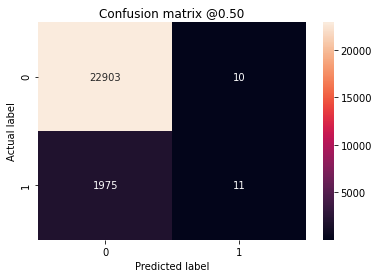

In [206]:
# confusion matrix for test
'''
                    Predicted
                  0          1
        0         TN         FP
Actual 
        1         FN         TP
'''

conf_matrix_rf_te = confusion_matrix(pred_rf_te>cm_prob_threshold, y_test )

print(conf_matrix_rf)

conf_matrix_rf_report = classification_report(pred_rf_te>cm_prob_threshold, y_test )
print(conf_matrix_rf_report)
sns.heatmap(conf_matrix_rf_te, annot=True, fmt = 'd')
plt.title('Confusion matrix @{:.2f}'.format(cm_prob_threshold))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')